In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data = pd.read_csv('credit_card_approval.csv')
# Remove the missing values
data = data.dropna()

# Drop the ID
data.drop('ID', axis=1, inplace=True)

# Split the data into features and target
features = data.drop('TARGET', axis=1)
target = data['TARGET']

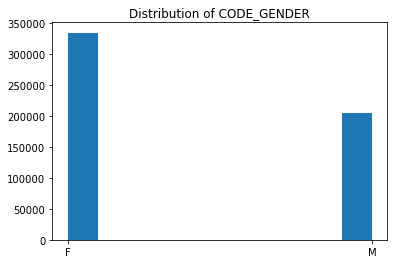

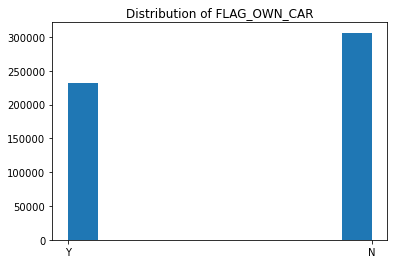

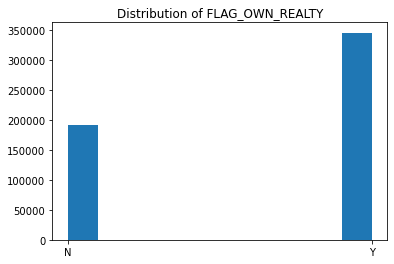

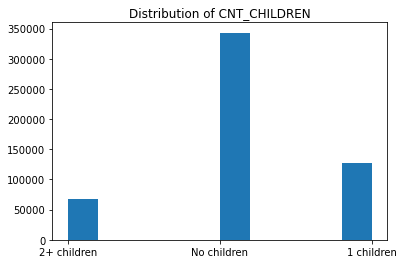

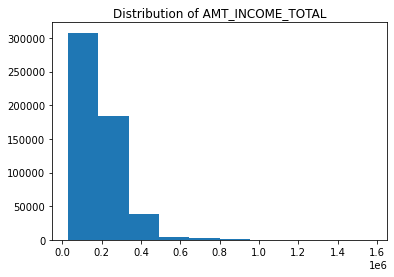

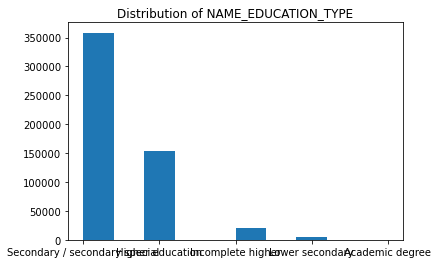

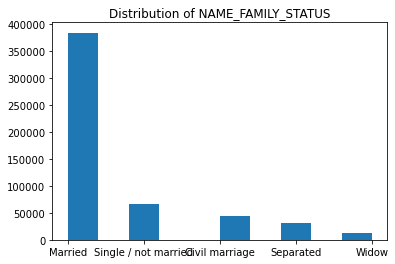

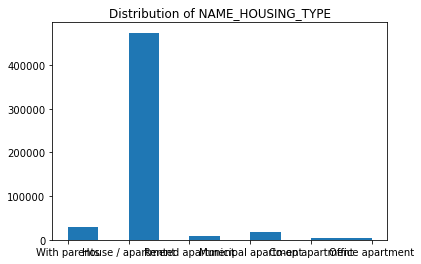

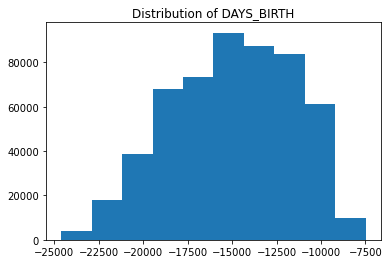

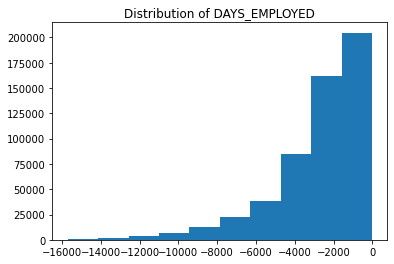

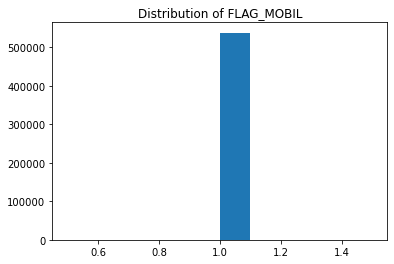

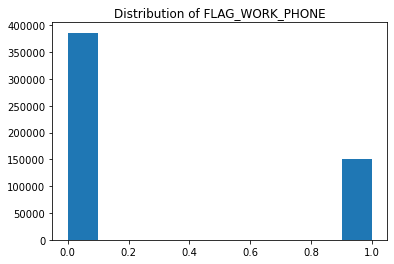

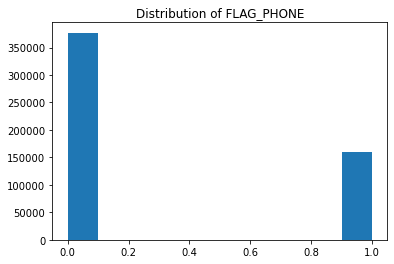

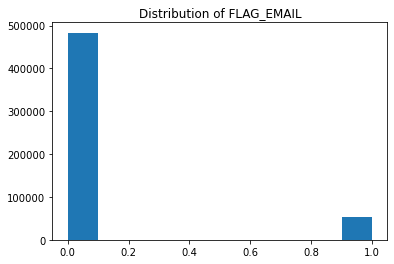

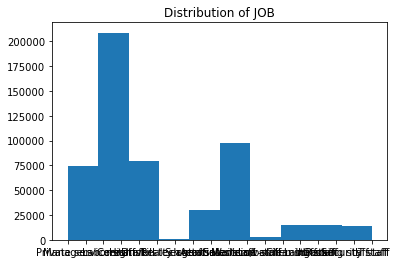

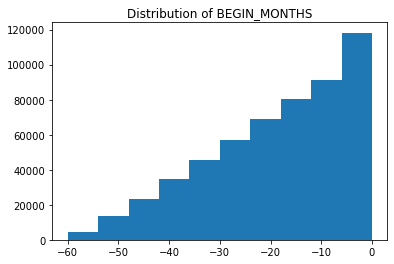

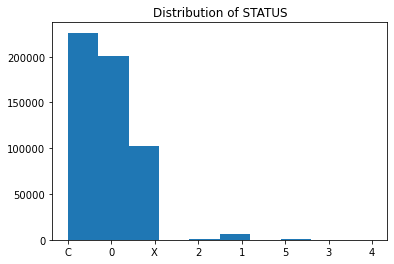

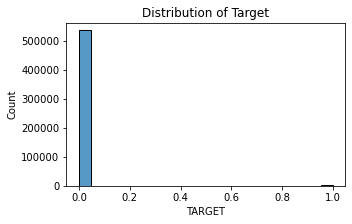

In [4]:
# Visualize the distribution of the features and target
for column in features.columns:
    plt.hist(features[column])
    plt.title(f'Distribution of {column}')
    plt.show()
plt.figure(figsize=(5, 3))
sns.histplot(target)
plt.title('Distribution of Target')
plt.show()



30 principal components that explain 80% of the variance.


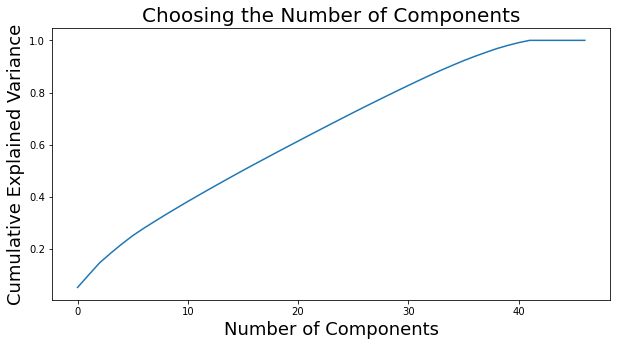

In [5]:


# print(data.head())

data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
data['BEGIN_MONTHS'] = abs(data['BEGIN_MONTHS'])


#  Encode the gender, flag_own_car columns and flag_own_realty, F as 1, M as 0, and Y as 1, N as 0.
data['CODE_GENDER'] = data['CODE_GENDER'].map({'F': 1, 'M': 0})
data['FLAG_OWN_CAR'] = data['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
data['FLAG_OWN_REALTY'] = data['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})


# Preprocess the children column, replace "2+ Children" with 2, "1 Child" with 1, and "No Children" with 0.
def process_children(x):
    if 'No children' in x:
        return 0
    elif '1 children' in x:
        return 1
    elif '2+ children' in x:
        return 2

    else:
        return None
data['CNT_CHILDREN'] = data['CNT_CHILDREN'].apply(process_children)

# One-hot encode the columns NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, and JOB.
data = pd.get_dummies(data, columns=['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'JOB'])

# Defite status
status_mapping = {
    '0': 1,   # 1-29 days past due
    '1': 2,   # 30-59 days past due
    '2': 3,   # 60-89 days overdue
    '3': 4,   # 90-119 days overdue
    '4': 5,   # 120-149 days overdue
    '5': 6,   # Overdue or bad debts, write-offs for more than 150 days
    'C': 0,   # paid off that month
    'X': -1   # No loan for the month
}

data['STATUS'] = data['STATUS'].map(status_mapping)


# Split the data into features and target
features = data.drop('TARGET', axis=1)
target = data['TARGET']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA()
pca.fit(X_train)
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components',fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
ax.set_title('Choosing the Number of Components',fontsize=20)
# Determine the number of principal components that explain 80% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.8) + 1
print(f'{n_components} principal components that explain 80% of the variance.')

# Apply PCA to the data
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)





In [6]:
# !pip install scikit-optimize

In [10]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Choose a subset of the train set, pick 20% in each class.
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42) 

# Initialize the Random Forest model
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# Define the parameter space for Random Forest
search_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(3, 40),
    'min_samples_split': Integer(2, 30),
    'min_samples_leaf': Integer(1, 30),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy'])
}

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the BayesSearchCV object with 5-fold cross-validation
bayes_cv_tuner = BayesSearchCV(
    estimator = rf,
    search_spaces = search_space,
    scoring = 'accuracy',
    cv = kf,
    n_iter = 20,  
    n_jobs = -1,   
    return_train_score = True,
    refit = True, 
    random_state = 42
)

# Run the Bayesian optimization search
bayes_cv_tuner.fit(X_sample, y_sample)

# Print the best parameters found
print(f"Best parameters found: {bayes_cv_tuner.best_params_}")

# Get the best model
best_rf_model = bayes_cv_tuner.best_estimator_



Best parameters found: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 35), ('min_samples_leaf', 13), ('min_samples_split', 13), ('n_estimators', 142)])


In [11]:
y_pred_test = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107157
           1       0.99      0.78      0.87       377

    accuracy                           1.00    107534
   macro avg       0.99      0.89      0.93    107534
weighted avg       1.00      1.00      1.00    107534



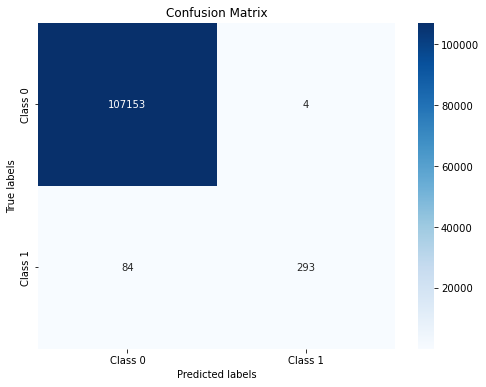

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_test, y_pred_test)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
